In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import pickle

In [30]:
__tenors__ = [0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30]

In [ ]:
ois_df = pd.read_excel("data/IR Data.xlsx", sheet_name="OIS")
ois_df = ois_df[['Tenor','Product','Rate']]
ois_df

,Tenor,Product,Rate
0,6m,OIS,0.00250
1,1y,OIS,0.00300
2,2y,OIS,0.00325
3,3y,OIS,0.00335
4,4y,OIS,0.00350
5,5y,OIS,0.00360
6,7y,OIS,0.00400
7,10y,OIS,0.00450
8,15y,OIS,0.00500
9,20y,OIS,0.00525


The daily accrued floating leg can be simplified as below
\begin{equation*}
  \begin{split}
    \prod_{i=1}^{N} (1+\Delta_{i-1} f_o(t_{i-1},t_i)) &= \prod_{i=1}^{N} (1+\Delta_{i-1} \cdot \dfrac{D_o(0,t_{i-1}) - D_o(0,t_i)}{\Delta_{i-1} \cdot D_o(0,t_i)})\\
    &= \prod_{i=1}^{N} \dfrac{D_o(0,t_{i-1})}{D_o(0,t_i)}\\
    &= \dfrac{D_o(0,t_1)}{D_o(0,t_N)}
  \end{split}
\end{equation*}
So, 
\begin{equation*}
  (1+\dfrac {f_{6m}}{180})^{180} = \dfrac{1}{D_o(0,6m)},\quad (1+\dfrac {f_{1y}}{180})^{180} = \dfrac{D_o(0,6m)}{D_o(0,1y)},\quad (1+\dfrac {f_{2y}}{360})^{180} = \dfrac{D_o(0,1y)}{D_o(0,2y)},\quad ...
\end{equation*}
Substitute into the equation $PV_{fix}=PV_{flt}$, we get
\begin{equation*}
  \begin{split}
    D_o(0,6m)\times 0.5\times 0.25\% &= D_o(0,6m)\times [(1+\dfrac{f_{6m}}{360})^{180}-1] \\
    &= 1-D_o(0,6m) \\
    D_o(0,1y)\times 0.3\% &= D_o(0,1y)\times [(1+\dfrac{f_{6m}}{360})^{180}(1+\dfrac{f_{1y}}{360})^{180}-1] \\
    &= 1-D_o(0,1y) \\
    [D_o(0,1y)+D_o(0,2y)]\times 0.325\% &= D_o(0,1y)\times [(1+\dfrac{f_{6m}}{360})^{180}(1+\dfrac{f_{1y}}{360})^{180}-1]+D_o(0,2y)\times [(1+\dfrac{f_{2y}}{360})^{180}-1] \\
    &= 1-D_o(0,2y) \\
    ...
  \end{split}
\end{equation*}
For the fixed leg, $\Sigma_{i}^{N} D_o(0,t_i)$ changes a bit for those that need intopolation on discount factors
\begin{equation*}
  \begin{split}
    \Sigma_{i=1}^{7} D_o(0,iy) &= D_o(0,1y)+...+D_o(0,5y)+\dfrac{D_o(0,5y)+D_o(0,7y)}{2}+D_o(0,7y)\\
    &=\Sigma_{i=1}^{4} D_o(0,iy)+1.5\cdot D_o(0,5y)+1.5\cdot D_o(0,7y)\\
    \Sigma_{i=1}^{10} D_o(0,iy) &= \Sigma_{i=1}^{4} D_o(0,iy)+1.5\cdot D_o(0,5y)+2.5\cdot D_o(0,7y)+2\cdot D_o(0,10y)\\
    \Sigma_{i=1}^{15} D_o(0,iy) &= \Sigma_{i=1}^{4} D_o(0,iy)+1.5\cdot D_o(0,5y)+2.5\cdot D_o(0,7y)+4\cdot D_o(0,10y)+3\cdot D_o(0,15y)\\
    \Sigma_{i=1}^{20} D_o(0,iy) &= \Sigma_{i=1}^{4} D_o(0,iy)+1.5\cdot D_o(0,5y)+2.5\cdot D_o(0,7y)+4\cdot D_o(0,10y)+5\cdot D_o(0,15y)+3\cdot D_o(0,20y)\\
    \Sigma_{i=1}^{30} D_o(0,iy) &= \Sigma_{i=1}^{4} D_o(0,iy)+1.5\cdot D_o(0,5y)+2.5\cdot D_o(0,7y)+4\cdot D_o(0,10y)+5\cdot D_o(0,15y)+7.5\cdot D_o(0,20y)+5.5\cdot D_o(0,30y)
  \end{split}
\end{equation*}


In [ ]:
Do_6m = 1.0/(1+0.5*ois_df['Rate'][0])
Do_1y = 1.0/(1+ois_df['Rate'][1])
Do_2y = (1-Do_1y*ois_df['Rate'][2])/(1+ois_df['Rate'][2])
Do_3y = (1-(Do_1y+Do_2y)*ois_df['Rate'][3])/(1+ois_df['Rate'][3])
Do_4y = (1-(Do_1y+Do_2y+Do_3y)*ois_df['Rate'][4])/(1+ois_df['Rate'][4])
Do_5y = (1-(Do_1y+Do_2y+Do_3y+Do_4y)*ois_df['Rate'][5])/(1+ois_df['Rate'][5])
Do_7y = (1-(Do_1y+Do_2y+Do_3y+Do_4y+1.5*Do_5y)*ois_df['Rate'][6])/(1+1.5*ois_df['Rate'][6])
Do_10y = (1-(Do_1y+Do_2y+Do_3y+Do_4y+1.5*Do_5y+2.5*Do_7y)*ois_df['Rate'][7])/(1+2*ois_df['Rate'][7])
Do_15y = (1-(Do_1y+Do_2y+Do_3y+Do_4y+1.5*Do_5y+2.5*Do_7y+4*Do_10y)*ois_df['Rate'][8])/(1+3*ois_df['Rate'][8])
Do_20y = (1-(Do_1y+Do_2y+Do_3y+Do_4y+1.5*Do_5y+2.5*Do_7y+4*Do_10y+5*Do_15y)*ois_df['Rate'][9])/(1+3*ois_df['Rate'][9])
Do_30y = (1-(Do_1y+Do_2y+Do_3y+Do_4y+1.5*Do_5y+2.5*Do_7y+4*Do_10y+5*Do_15y+7.5*Do_20y)*ois_df['Rate'][10])/(1+5.5*ois_df['Rate'][10])
[Do_6m, Do_1y, Do_2y, Do_3y, Do_4y, Do_5y, Do_7y, Do_10y, Do_15y, Do_20y, Do_30y]

[0.9987515605493134,
 0.9970089730807579,
 0.9935307459132694,
 0.9900151412182888,
 0.9861166497152534,
 0.9821841197332211,
 0.9724057745943244,
 0.9559768785262048,
 0.92761147960533,
 0.9000759370413394,
 0.8474067157362281]

In [33]:
ois_discount_curve = interp1d(__tenors__, [Do_6m, Do_1y, Do_2y, Do_3y, Do_4y, Do_5y, Do_7y, Do_10y, Do_15y, Do_20y, Do_30y])

In [ ]:
irs_df = pd.read_excel("data/IR Data.xlsx", sheet_name="IRS")
irs_df = irs_df[['Tenor','Product','Rate']]
irs_df

,Tenor,Product,Rate
0,6m,LIBOR,0.0250
1,1y,IRS,0.0280
2,2y,IRS,0.0300
3,3y,IRS,0.0315
4,4y,IRS,0.0325
5,5y,IRS,0.0330
6,7y,IRS,0.0350
7,10y,IRS,0.0370
8,15y,IRS,0.0400
9,20y,IRS,0.0450


We want to use the equation $PV_{fix}=PV_{flt}$ to derive LIBOR first
\begin{equation*}
  \begin{split}
    PV_{fix} &= \Sigma_{i=1}^N D_o(0,T_i)\cdot 0.5\cdot S \\
    PV_{flt} &= \Sigma_{i=1}^N D_o(0,T_i)\cdot 0.5\cdot L(T_{i-1},T_i)
  \end{split}
\end{equation*}
We are able to calculate the fixed legs already using overnight discount curve and the given IRS rates
\begin{equation*}
  \begin{split}
    PV_{fix,1y} &= [D_o(0,6m)+D_o(0,1y)]\cdot 0.5\cdot 2.8\% \\
    PV_{fix,2y} &= [D_o(0,6m)+D_o(0,1y)+D_o(0,1.5y)+D_o(0,2y)]\cdot 0.5\cdot 3\% \\
    ...
  \end{split}
\end{equation*}
However the floating legs have more unknown variables than equations
\begin{equation*}
  \begin{split}
    PV_{flt,1y} &= D_o(0,6m)\cdot 0.5\cdot L(0,6m) + D_o(0,1y)\cdot 0.5\cdot L(6m,1y) \\
    PV_{flt,2y} &= D_o(0,6m)\cdot 0.5\cdot L(0,6m) + D_o(0,1y)\cdot 0.5\cdot L(6m,1y) + D_o(0,1.5y)\cdot 0.5\cdot L(1y,1.5y)+D_o(0,2y)\cdot 0.5\cdot L(1.5y,2y) \\
    ...
  \end{split}
\end{equation*}
To make the number of unknown variables same as number of equations, we need to replace them with the following LIBOR only, 
$$
  L(1,2),\quad L(2,3),\quad L(3,4),\quad L(4,5),\quad L(5,7),\quad L(7,10),\quad L(10,15),\quad L(15,20),\quad L(20,30)
$$
For example:

Given
\begin{equation*}
  \begin{split}
    L(1,2) &= \dfrac{D(0,1)-D(0,2)}{D(0,2)}\\
    D(0,1.5) &= \dfrac{1}{2}D(0,1) + \dfrac{1}{2}D(0,2)
  \end{split}
\end{equation*}
we can have
\begin{equation*}
  \begin{split}
    0.5\cdot L(1,1.5) &= \dfrac{D(0,1)-D(0,1.5)}{D(0,1.5)} = \dfrac{D(0,1)-D(0,2)}{D(0,1)+D(0,2)} = \dfrac{L(1,2)}{L(1,2)+2}\\
    0.5\cdot L(1.5,2) &= \dfrac{D(0,1.5)-D(0,2)}{D(0,2)} = \dfrac{D(0,1)-D(0,2)}{2\cdot D(0,2)} = \dfrac{L(1,2)}{2}\\
  \end{split}
\end{equation*}
Similarly
\begin{equation*}
  \begin{split}
    0.5\cdot L(5,5.5) &= \dfrac{L(5,7)}{3\cdot L(5,7)+2}\\
    0.5\cdot L(5.5,6) &= \dfrac{L(5,7)}{2\cdot L(5,7)+2}\\
    0.5\cdot L(6,6.5) &= \dfrac{L(5,7)}{L(5,7)+2}\\
    0.5\cdot L(6.5,7) &= \dfrac{L(5,7)}{2}\\
    0.5\cdot L(7,7.5) &= \dfrac{L(7,10)}{5\cdot L(7,10)+2}\\
    0.5\cdot L(7.5,8) &= \dfrac{L(7,10)}{4\cdot L(7,10)+2}\\
    0.5\cdot L(8,8.5) &= \dfrac{L(7,10)}{3\cdot L(7,10)+2}\\
    0.5\cdot L(8.5,9) &= \dfrac{L(7,10)}{2\cdot L(7,10)+2}\\
    0.5\cdot L(9,9.5) &= \dfrac{L(7,10)}{L(7,10)+2}\\
    0.5\cdot L(9.5,10) &= \dfrac{L(7,10)}{2}\\
    0.5\cdot L(10,10.5) &= \dfrac{L(10,15)}{9\cdot L(10,15)+2}\\
    0.5\cdot L(10.5,11) &= \dfrac{L(10,15)}{8\cdot L(10,15)+2}\\
    0.5\cdot L(11,11.5) &= \dfrac{L(10,15)}{7\cdot L(10,15)+2}\\
    0.5\cdot L(11.5,12) &= \dfrac{L(10,15)}{6\cdot L(10,15)+2}\\
    0.5\cdot L(12,12.5) &= \dfrac{L(10,15)}{5\cdot L(10,15)+2}\\
    0.5\cdot L(12.5,13) &= \dfrac{L(10,15)}{4\cdot L(10,15)+2}\\
    0.5\cdot L(13,13.5) &= \dfrac{L(10,15)}{3\cdot L(10,15)+2}\\
    0.5\cdot L(13.5,14) &= \dfrac{L(10,15)}{2\cdot L(10,15)+2}\\
    0.5\cdot L(14,14.5) &= \dfrac{L(10,15)}{L(10,15)+2}\\
    0.5\cdot L(14.5,15) &= \dfrac{L(10,15)}{2}\\
    0.5\cdot L(20,20.5) &= \dfrac{L(20,30)}{19\cdot L(20,30)+2}\\
    0.5\cdot L(20.5,21) &= \dfrac{L(20,30)}{18\cdot L(20,30)+2}\\
    0.5\cdot L(21,21.5) &= \dfrac{L(20,30)}{17\cdot L(20,30)+2}\\
    0.5\cdot L(21.5,22) &= \dfrac{L(20,30)}{16\cdot L(20,30)+2}\\
    0.5\cdot L(22,22.5) &= \dfrac{L(20,30)}{15\cdot L(20,30)+2}\\
    0.5\cdot L(22.5,23) &= \dfrac{L(20,30)}{14\cdot L(20,30)+2}\\
    0.5\cdot L(23,23.5) &= \dfrac{L(20,30)}{13\cdot L(20,30)+2}\\
    0.5\cdot L(23.5,24) &= \dfrac{L(20,30)}{12\cdot L(20,30)+2}\\
    0.5\cdot L(24,24.5) &= \dfrac{L(20,30)}{11\cdot L(20,30)+2}\\
    0.5\cdot L(24.5,25) &= \dfrac{L(20,30)}{10\cdot L(20,30)+2}\\
    0.5\cdot L(25,25.5) &= \dfrac{L(20,30)}{9\cdot L(20,30)+2}\\
    0.5\cdot L(25.5,26) &= \dfrac{L(20,30)}{8\cdot L(20,30)+2}\\
    0.5\cdot L(26,26.5) &= \dfrac{L(20,30)}{7\cdot L(20,30)+2}\\
    0.5\cdot L(26.5,27) &= \dfrac{L(20,30)}{6\cdot L(20,30)+2}\\
    0.5\cdot L(27,27.5) &= \dfrac{L(20,30)}{5\cdot L(20,30)+2}\\
    0.5\cdot L(27.5,28) &= \dfrac{L(20,30)}{4\cdot L(20,30)+2}\\
    0.5\cdot L(28,28.5) &= \dfrac{L(20,30)}{3\cdot L(20,30)+2}\\
    0.5\cdot L(28.5,29) &= \dfrac{L(20,30)}{2\cdot L(20,30)+2}\\
    0.5\cdot L(29,29.5) &= \dfrac{L(20,30)}{L(20,30)+2}\\
    0.5\cdot L(29.5,30) &= \dfrac{L(20,30)}{2}\\
  \end{split}
\end{equation*}
By substituting the above equations into the floating legs, we can derive LIBOR and discount factors.

In [ ]:
Do = ois_discount_curve

L_6m = irs_df['Rate'][0] # L(0,6m)

N = __tenors__[1]
S = irs_df['Rate'][1]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*x
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_6m)
L_6m_1y = result.x[0]

N = __tenors__[2]
S = irs_df['Rate'][2]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*x/(x+2) \
                    + Do(2)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_6m_1y)
L_1y_2y = result.x[0]

N = __tenors__[3]
S = irs_df['Rate'][3]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*x/(x+2) \
                    + Do(3)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_1y_2y)
L_2y_3y = result.x[0]

N = __tenors__[4]
S = irs_df['Rate'][4]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*L_2y_3y/(L_2y_3y+2) \
                    + Do(3)*L_2y_3y/2 \
                    + Do(3.5)*x/(x+2) \
                    + Do(4)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_2y_3y)
L_3y_4y = result.x[0]

N = __tenors__[5]
S = irs_df['Rate'][5]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*L_2y_3y/(L_2y_3y+2) \
                    + Do(3)*L_2y_3y/2 \
                    + Do(3.5)*L_3y_4y/(L_3y_4y+2) \
                    + Do(4)*L_3y_4y/2 \
                    + Do(4.5)*x/(x+2) \
                    + Do(5)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_3y_4y)
L_4y_5y = result.x[0]

N = __tenors__[6]
S = irs_df['Rate'][6]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*L_2y_3y/(L_2y_3y+2) \
                    + Do(3)*L_2y_3y/2 \
                    + Do(3.5)*L_3y_4y/(L_3y_4y+2) \
                    + Do(4)*L_3y_4y/2 \
                    + Do(4.5)*L_4y_5y/(L_4y_5y+2) \
                    + Do(5)*L_4y_5y/2 \
                    + Do(5.5)*x/(3*x+2) \
                    + Do(6)*x/(2*x+2) \
                    + Do(6.5)*x/(x+2) \
                    + Do(7)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_4y_5y)
L_5y_7y = result.x[0]

N = __tenors__[7]
S = irs_df['Rate'][7]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*L_2y_3y/(L_2y_3y+2) \
                    + Do(3)*L_2y_3y/2 \
                    + Do(3.5)*L_3y_4y/(L_3y_4y+2) \
                    + Do(4)*L_3y_4y/2 \
                    + Do(4.5)*L_4y_5y/(L_4y_5y+2) \
                    + Do(5)*L_4y_5y/2 \
                    + Do(5.5)*L_5y_7y/(3*L_5y_7y+2) \
                    + Do(6)*L_5y_7y/(2*L_5y_7y+2) \
                    + Do(6.5)*L_5y_7y/(L_5y_7y+2) \
                    + Do(7)*L_5y_7y/2 \
                    + Do(7.5)*x/(5*x+2) \
                    + Do(8)*x/(4*x+2) \
                    + Do(8.5)*x/(3*x+2) \
                    + Do(9)*x/(2*x+2) \
                    + Do(9.5)*x/(x+2) \
                    + Do(10)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_5y_7y)
L_7y_10y = result.x[0]

N = __tenors__[8]
S = irs_df['Rate'][8]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*L_2y_3y/(L_2y_3y+2) \
                    + Do(3)*L_2y_3y/2 \
                    + Do(3.5)*L_3y_4y/(L_3y_4y+2) \
                    + Do(4)*L_3y_4y/2 \
                    + Do(4.5)*L_4y_5y/(L_4y_5y+2) \
                    + Do(5)*L_4y_5y/2 \
                    + Do(5.5)*L_5y_7y/(3*L_5y_7y+2) \
                    + Do(6)*L_5y_7y/(2*L_5y_7y+2) \
                    + Do(6.5)*L_5y_7y/(L_5y_7y+2) \
                    + Do(7)*L_5y_7y/2 \
                    + Do(7.5)*L_7y_10y/(5*L_7y_10y+2) \
                    + Do(8)*L_7y_10y/(4*L_7y_10y+2) \
                    + Do(8.5)*L_7y_10y/(3*L_7y_10y+2) \
                    + Do(9)*L_7y_10y/(2*L_7y_10y+2) \
                    + Do(9.5)*L_7y_10y/(L_7y_10y+2) \
                    + Do(10)*L_7y_10y/2 \
                    + Do(10.5)*x/(9*x+2) \
                    + Do(11)*x/(8*x+2) \
                    + Do(11.5)*x/(7*x+2) \
                    + Do(12)*x/(6*x+2) \
                    + Do(12.5)*x/(5*x+2) \
                    + Do(13)*x/(4*x+2) \
                    + Do(13.5)*x/(3*x+2) \
                    + Do(14)*x/(2*x+2) \
                    + Do(14.5)*x/(x+2) \
                    + Do(15)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_7y_10y)
L_10y_15y = result.x[0]

N = __tenors__[9]
S = irs_df['Rate'][9]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*L_2y_3y/(L_2y_3y+2) \
                    + Do(3)*L_2y_3y/2 \
                    + Do(3.5)*L_3y_4y/(L_3y_4y+2) \
                    + Do(4)*L_3y_4y/2 \
                    + Do(4.5)*L_4y_5y/(L_4y_5y+2) \
                    + Do(5)*L_4y_5y/2 \
                    + Do(5.5)*L_5y_7y/(3*L_5y_7y+2) \
                    + Do(6)*L_5y_7y/(2*L_5y_7y+2) \
                    + Do(6.5)*L_5y_7y/(L_5y_7y+2) \
                    + Do(7)*L_5y_7y/2 \
                    + Do(7.5)*L_7y_10y/(5*L_7y_10y+2) \
                    + Do(8)*L_7y_10y/(4*L_7y_10y+2) \
                    + Do(8.5)*L_7y_10y/(3*L_7y_10y+2) \
                    + Do(9)*L_7y_10y/(2*L_7y_10y+2) \
                    + Do(9.5)*L_7y_10y/(L_7y_10y+2) \
                    + Do(10)*L_7y_10y/2 \
                    + Do(10.5)*L_10y_15y/(9*L_10y_15y+2) \
                    + Do(11)*L_10y_15y/(8*L_10y_15y+2) \
                    + Do(11.5)*L_10y_15y/(7*L_10y_15y+2) \
                    + Do(12)*L_10y_15y/(6*L_10y_15y+2) \
                    + Do(12.5)*L_10y_15y/(5*L_10y_15y+2) \
                    + Do(13)*L_10y_15y/(4*L_10y_15y+2) \
                    + Do(13.5)*L_10y_15y/(3*L_10y_15y+2) \
                    + Do(14)*L_10y_15y/(2*L_10y_15y+2) \
                    + Do(14.5)*L_10y_15y/(L_10y_15y+2) \
                    + Do(15)*L_10y_15y/2 \
                    + Do(15.5)*x/(9*x+2) \
                    + Do(16)*x/(8*x+2) \
                    + Do(16.5)*x/(7*x+2) \
                    + Do(17)*x/(6*x+2) \
                    + Do(17.5)*x/(5*x+2) \
                    + Do(18)*x/(4*x+2) \
                    + Do(18.5)*x/(3*x+2) \
                    + Do(19)*x/(2*x+2) \
                    + Do(19.5)*x/(x+2) \
                    + Do(20)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_10y_15y)
L_15y_20y = result.x[0]

N = __tenors__[10]
S = irs_df['Rate'][10]
PV_fix = (Do(np.arange(N, 0, -0.5)).sum())*0.5*S
PV_flt = lambda x: Do(0.5)*0.5*L_6m \
                    + Do(1)*0.5*L_6m_1y \
                    + Do(1.5)*L_1y_2y/(L_1y_2y+2) \
                    + Do(2)*L_1y_2y/2 \
                    + Do(2.5)*L_2y_3y/(L_2y_3y+2) \
                    + Do(3)*L_2y_3y/2 \
                    + Do(3.5)*L_3y_4y/(L_3y_4y+2) \
                    + Do(4)*L_3y_4y/2 \
                    + Do(4.5)*L_4y_5y/(L_4y_5y+2) \
                    + Do(5)*L_4y_5y/2 \
                    + Do(5.5)*L_5y_7y/(3*L_5y_7y+2) \
                    + Do(6)*L_5y_7y/(2*L_5y_7y+2) \
                    + Do(6.5)*L_5y_7y/(L_5y_7y+2) \
                    + Do(7)*L_5y_7y/2 \
                    + Do(7.5)*L_7y_10y/(5*L_7y_10y+2) \
                    + Do(8)*L_7y_10y/(4*L_7y_10y+2) \
                    + Do(8.5)*L_7y_10y/(3*L_7y_10y+2) \
                    + Do(9)*L_7y_10y/(2*L_7y_10y+2) \
                    + Do(9.5)*L_7y_10y/(L_7y_10y+2) \
                    + Do(10)*L_7y_10y/2 \
                    + Do(10.5)*L_10y_15y/(9*L_10y_15y+2) \
                    + Do(11)*L_10y_15y/(8*L_10y_15y+2) \
                    + Do(11.5)*L_10y_15y/(7*L_10y_15y+2) \
                    + Do(12)*L_10y_15y/(6*L_10y_15y+2) \
                    + Do(12.5)*L_10y_15y/(5*L_10y_15y+2) \
                    + Do(13)*L_10y_15y/(4*L_10y_15y+2) \
                    + Do(13.5)*L_10y_15y/(3*L_10y_15y+2) \
                    + Do(14)*L_10y_15y/(2*L_10y_15y+2) \
                    + Do(14.5)*L_10y_15y/(L_10y_15y+2) \
                    + Do(15)*L_10y_15y/2 \
                    + Do(15.5)*L_15y_20y/(9*L_15y_20y+2) \
                    + Do(16)*L_15y_20y/(8*L_15y_20y+2) \
                    + Do(16.5)*L_15y_20y/(7*L_15y_20y+2) \
                    + Do(17)*L_15y_20y/(6*L_15y_20y+2) \
                    + Do(17.5)*L_15y_20y/(5*L_15y_20y+2) \
                    + Do(18)*L_15y_20y/(4*L_15y_20y+2) \
                    + Do(18.5)*L_15y_20y/(3*L_15y_20y+2) \
                    + Do(19)*L_15y_20y/(2*L_15y_20y+2) \
                    + Do(19.5)*L_15y_20y/(L_15y_20y+2) \
                    + Do(20)*L_15y_20y/2 \
                    + Do(20.5)*x/(19*x+2) \
                    + Do(21)*x/(18*x+2) \
                    + Do(21.5)*x/(17*x+2) \
                    + Do(22)*x/(16*x+2) \
                    + Do(22.5)*x/(15*x+2) \
                    + Do(23)*x/(14*x+2) \
                    + Do(23.5)*x/(13*x+2) \
                    + Do(24)*x/(12*x+2) \
                    + Do(24.5)*x/(11*x+2) \
                    + Do(25)*x/(10*x+2) \
                    + Do(25.5)*x/(9*x+2) \
                    + Do(26)*x/(8*x+2) \
                    + Do(26.5)*x/(7*x+2) \
                    + Do(27)*x/(6*x+2) \
                    + Do(27.5)*x/(5*x+2) \
                    + Do(28)*x/(4*x+2) \
                    + Do(28.5)*x/(3*x+2) \
                    + Do(29)*x/(2*x+2) \
                    + Do(29.5)*x/(x+2) \
                    + Do(30)*x/2
residual_func = lambda x: PV_flt(x) - PV_fix
result = least_squares(residual_func, L_15y_20y)
L_20y_30y = result.x[0]

[L_6m, L_6m_1y, L_1y_2y, L_2y_3y, L_3y_4y, L_4y_5y, L_5y_7y, L_7y_10y, L_10y_15y, L_15y_20y, L_20y_30y]

[0.025,
 0.03100524344737632,
 0.03226332225254118,
 0.03481396645444228,
 0.035837935758486,
 0.03532599340876196,
 0.04129798535483237,
 0.04403276571824741,
 0.051400690025487555,
 0.06999360979226266,
 0.08251504576796674]

In [53]:
D_6m = 1.0/(1+0.5*L_6m)
D_1y = D_6m/(1+0.5*L_6m_1y)
D_2y = D_1y/(1+1*L_1y_2y)
D_3y = D_2y/(1+1*L_2y_3y)
D_4y = D_3y/(1+1*L_3y_4y)
D_5y = D_4y/(1+1*L_4y_5y)
D_7y = D_5y/(1+2*L_5y_7y)
D_10y = D_7y/(1+3*L_7y_10y)
D_15y = D_10y/(1+5*L_10y_15y)
D_20y = D_15y/(1+5*L_15y_20y)
D_30y = D_20y/(1+10*L_20y_30y)
[D_6m, D_1y, D_2y, D_3y, D_4y, D_5y, D_7y, D_10y, D_15y, D_20y, D_30y]

[0.9876543209876544,
 0.972576830290438,
 0.9421790054190251,
 0.9104815319097306,
 0.8789806788096017,
 0.848989288789707,
 0.7842161912289185,
 0.6927103354892927,
 0.5510806954579673,
 0.4082175840250275,
 0.2236624286547854]

In [54]:
libor_discount_curve = interp1d(__tenors__, [D_6m, D_1y, D_2y, D_3y, D_4y, D_5y, D_7y, D_10y, D_15y, D_20y, D_30y])

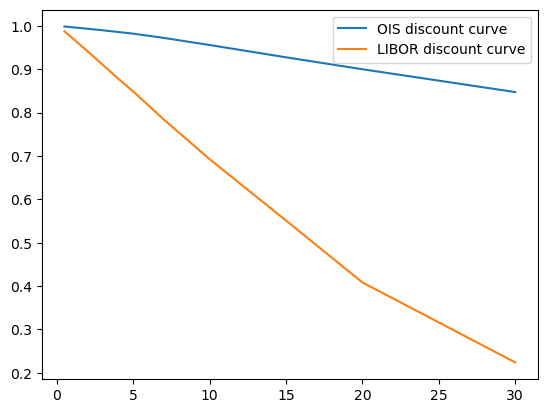

In [38]:
plt.plot(__tenors__, ois_discount_curve(__tenors__), label = "OIS discount curve")
plt.plot(__tenors__, libor_discount_curve(__tenors__), label = "LIBOR discount curve")
plt.legend()
plt.show()

Considering collateralization and semi-annual payment, forward swap rate is given by
\begin{equation*}
  \begin{split}
    S_{n,N} &= \dfrac{\Sigma_{i=n}^N D_o(0,T_i)\cdot 0.5\cdot L(T_{i-1},T_i)}{\Sigma_{i=n}^{N} 0.5 \cdot D_o(0,T_i)} \\
    &= \dfrac{\Sigma_{i=n}^N D_o(0,T_i)\cdot \dfrac{D(0,T_{i-1}) - D(0,T_i)}{D(0,T_i)}}{\Sigma_{i=n}^{N} 0.5 \cdot D_o(0,T_i)}
  \end{split}
\end{equation*}


In [71]:
# with open('data/ois_discount_curve.pkl', 'rb') as f:
#     ois_discount_curve = pickle.load(f)
# with open('data/libor_discount_curve.pkl', 'rb') as f:
#     libor_discount_curve = pickle.load(f)

def swap_pv01(Tn, N, freq):
    Do = ois_discount_curve
    TN = Tn + N
    dc = 1.0/freq # day count fraction
    return dc * (Do(np.arange(TN,Tn,-dc)).sum())

def swap_curve(Tn, N, freq):
    Do = ois_discount_curve
    D = libor_discount_curve
    TN = Tn + N
    PV01 = swap_pv01(Tn, N, freq)
    dc = 1.0/freq # day count fraction
    PV_flt = sum([Do(i)*(D(i-dc)-D(i))/D(i) if i>dc \
                  else Do(i)*(1-D(i))/D(i) \
                for i in np.arange(TN,Tn,-dc)])
    return PV_flt / PV01

In [ ]:
swap_rates = pd.DataFrame(index=[1,5,10]
                        , columns=[1,2,3,5,10])
for r in swap_rates.index:
    for c in swap_rates.columns:
        swap_rates.at[r, c] = swap_curve(r, c, freq=2)
swap_rates

,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [ ]:
pv01 = pd.DataFrame(index=[1,5,10]
                        , columns=[1,2,3,5,10])
for r in pv01.index:
    for c in pv01.columns:
        pv01.at[r, c] = swap_pv01(r, c, freq=2)
pv01

,1,2,3,5,10
1,0.9944,1.985294,2.972386,4.93407,9.747887
5,0.978517,1.952145,2.920444,4.840612,9.542492
10,0.951722,1.897771,2.838147,4.70188,9.264214


In [ ]:
# cross check spot swap rates against the excel data
# swap_curve(0, 30, 2)

0.049999999999906994

In [ ]:
# result output
# with pd.ExcelWriter("data/swap_rates.xlsx", mode='w') as writer:  
#     swap_rates.to_excel(writer, sheet_name="swap_rates")
#     pv01.to_excel(writer, sheet_name="pv01")

# import pickle
# with open('data/ov_df.pkl', 'wb') as f:
#     pickle.dump(Do, f) 
# with open('data/libor_df.pkl', 'wb') as f:
#     pickle.dump(D, f)